Coil force calculations for Next Step Fusion design
==========

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker, gs_Domain, create_isoflux

# Build mesh

## Define vacuum vessel geometry

In [3]:
lim2 = np.array([[ 1.36295616,  0.        ],
       [ 1.35819627,  0.1136394 ],
       [ 1.34411987,  0.22839392],
       [ 1.32147837,  0.33535708],
       [ 1.29160087,  0.428733  ],
       [ 1.25659351,  0.50348616],
       [ 1.21989537,  0.55532746],
       [ 1.18721657,  0.58207902],
       [ 1.16129551,  0.58932473],
       [ 1.0702428 ,  0.57841675],
       [ 0.97292215,  0.544273  ],
       [ 0.88082552,  0.48851609],
       [ 0.79867131,  0.41333246],
       [ 0.73043826,  0.32194035],
       [ 0.67936479,  0.2185339 ],
       [ 0.64782749,  0.10834806],
       [ 0.63723823,  0.        ],
       [ 0.64782749, -0.10834806],
       [ 0.67936479, -0.2185339 ],
       [ 0.73043826, -0.32194035],
       [ 0.79867131, -0.41333246],
       [ 0.88082552, -0.48851609],
       [ 0.97292215, -0.544273  ],
       [ 1.0702428 , -0.57841675],
       [ 1.16129551, -0.58932473],
       [ 1.18721657, -0.58207902],
       [ 1.21989537, -0.55532746],
       [ 1.25659351, -0.50348616],
       [ 1.29160087, -0.428733  ],
       [ 1.32147837, -0.33535708],
       [ 1.34411987, -0.22839392],
       [ 1.35819627, -0.1136394 ]])

vv2 = np.array([[ 1.37296493e+00, -1.38777878e-17],
       [ 1.36817072e+00,  1.14458731e-01],
       [ 1.35399275e+00,  2.30041200e-01],
       [ 1.33115684e+00,  3.37922814e-01],
       [ 1.30092944e+00,  4.32392306e-01],
       [ 1.26527112e+00,  5.08535482e-01],
       [ 1.22727606e+00,  5.62208864e-01],
       [ 1.19192830e+00,  5.91145285e-01],
       [ 1.16207641e+00,  5.99489787e-01],
       [ 1.06796580e+00,  5.88215468e-01],
       [ 9.68631600e-01,  5.53365296e-01],
       [ 8.74802348e-01,  4.96559420e-01],
       [ 7.91223325e-01,  4.20071879e-01],
       [ 7.21877594e-01,  3.27189432e-01],
       [ 6.69999158e-01,  2.22153185e-01],
       [ 6.37963346e-01,  1.10225658e-01],
       [ 6.27190584e-01, -6.93889390e-18],
       [ 6.37963346e-01, -1.10225658e-01],
       [ 6.69999158e-01, -2.22153185e-01],
       [ 7.21877594e-01, -3.27189432e-01],
       [ 7.91223325e-01, -4.20071879e-01],
       [ 8.74802348e-01, -4.96559420e-01],
       [ 9.68631600e-01, -5.53365296e-01],
       [ 1.06796580e+00, -5.88215468e-01],
       [ 1.16207641e+00, -5.99489787e-01],
       [ 1.19192830e+00, -5.91145285e-01],
       [ 1.22727606e+00, -5.62208864e-01],
       [ 1.26527112e+00, -5.08535482e-01],
       [ 1.30092944e+00, -4.32392306e-01],
       [ 1.33115684e+00, -3.37922814e-01],
       [ 1.35399275e+00, -2.30041200e-01],
       [ 1.36817072e+00, -1.14458731e-01]])

## Define coils

In [4]:
coils = {
    'CS0': {'rc': 0.550, 'zc': -.63, 'w': 0.1, 'h': 0.4},
    'CS1': {'rc': 0.550, 'zc': 0, 'w': 0.1, 'h': 0.8},
    'CS2': {'rc': 0.550, 'zc': .63, 'w': 0.1, 'h': 0.4},

    'EF0U': {'rc': .738, 'zc': 0.6, 'w': 0.15, 'h': 0.15},
    'EF1U': {'rc': 1.250, 'zc': 0.74, 'w': 0.175, 'h': 0.175},
    'EF2U': {'rc': 1.450, 'zc': 0.600, 'w': 0.15, 'h': 0.15},
    'EF3U': {'rc': 1.95, 'zc': 0.3, 'w': .175, 'h': .175},

    'EF0L': {'rc': .738, 'zc': -0.6, 'w': 0.15, 'h': 0.15},
    'EF1L': {'rc': 1.250, 'zc': -0.74, 'w': 0.175, 'h': 0.175},
    'EF2L': {'rc': 1.450, 'zc': -0.600, 'w': 0.15, 'h': 0.15},
    'EF3L': {'rc': 1.95, 'zc': -0.3, 'w': .175, 'h': .175},
  
}

## Define mesh resolution in each region

In [5]:
plasma_resolution = 0.02
coil_resolution = 0.02
vv_resolution = 0.03
vac_resolution = 0.075

## Define regions

In [6]:
# Create a G-S domain
gs_mesh = gs_Domain(zpad=[1.5,1.5])
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=8.67E-7)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [7]:
# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')


## Generate mesh

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 814
  # of unique segments  = 50
Generating mesh:
  # of points  = 5874
  # of cells   = 11616
  # of regions = 14


## Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed

In [9]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          40b94bd
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.088E+00
    # of points  =    5874
    # of edges   =   17489
    # of cells   =   11616
    # of boundary points =     130
    # of boundary edges  =     130
    # of boundary cells  =     130
  Resolution statistics:
    hmin =  1.000E-02
    hrms =  3.703E-02
    hmax =  1.0

# Compute forces on coils for a vacuum state

## Set coil currents and compute vacuum equilibrium

In [10]:
coil_currents = np.zeros((mygs.ncoils,), dtype=np.float64)
coil_currents[mygs.coil_sets['CS0']['id']] = -1.5E6
coil_currents[mygs.coil_sets['CS1']['id']] = -3.0E6
coil_currents[mygs.coil_sets['CS2']['id']] = -1.5E6

coil_currents[mygs.coil_sets['EF3U']['id']] = -1.E6
coil_currents[mygs.coil_sets['EF3L']['id']] = -1.E6

mygs.set_coil_currents(coil_currents)
mygs.set_psi(0.0*mygs.get_psi())
err_flag = mygs.solve(True)

   1  1.9241E+04


## Load toroidal coil mesh for for calculations

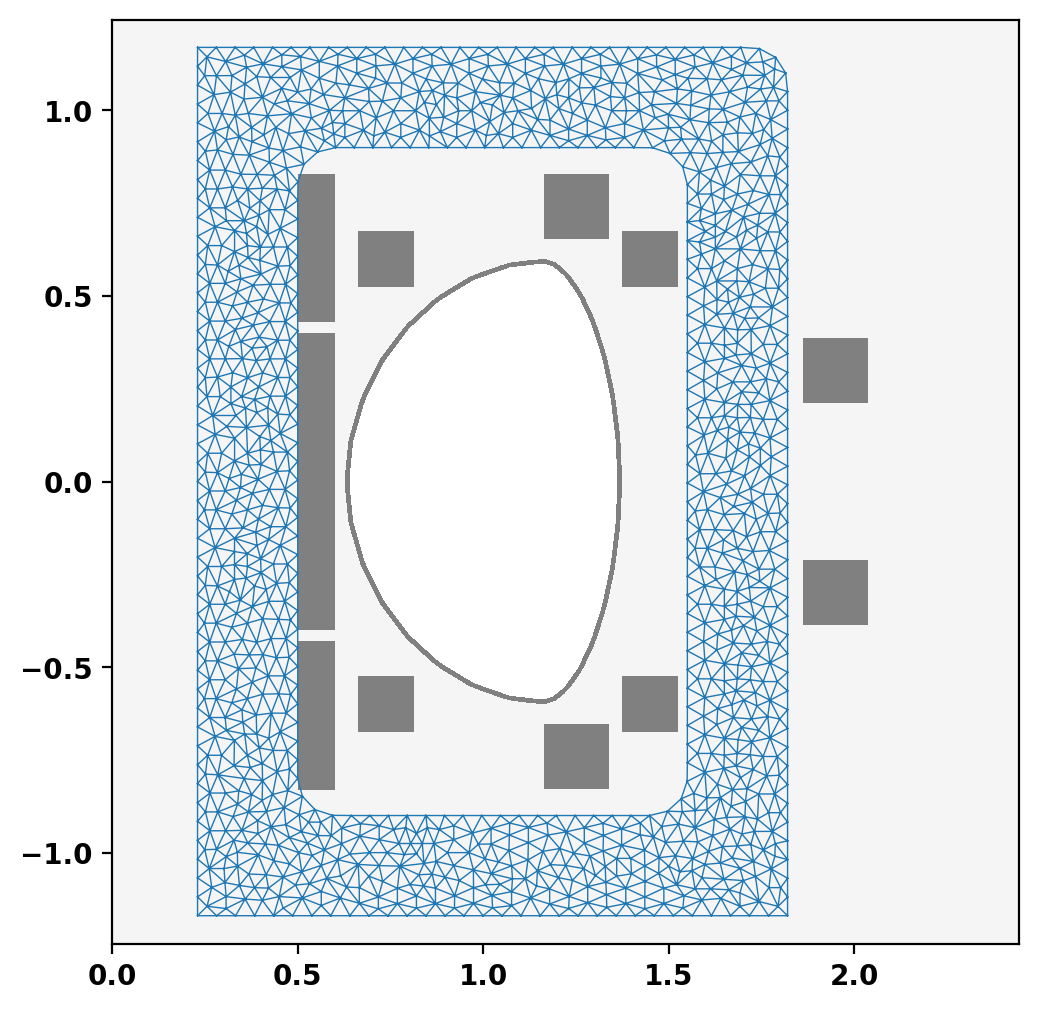

In [11]:
with open('TF_mesh.json', 'r') as fid:
    input_dict = json.load(fid)
tf_pts = np.array(input_dict['pts'])
tf_lc = np.array(input_dict['lc'])

# Plot mesh
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
_ = ax.triplot(tf_pts[:,0],tf_pts[:,1],tf_lc,lw=0.5)

## Sample B-field on TF grid points

Field is stored as \[B_r, B_phi, B_z\]

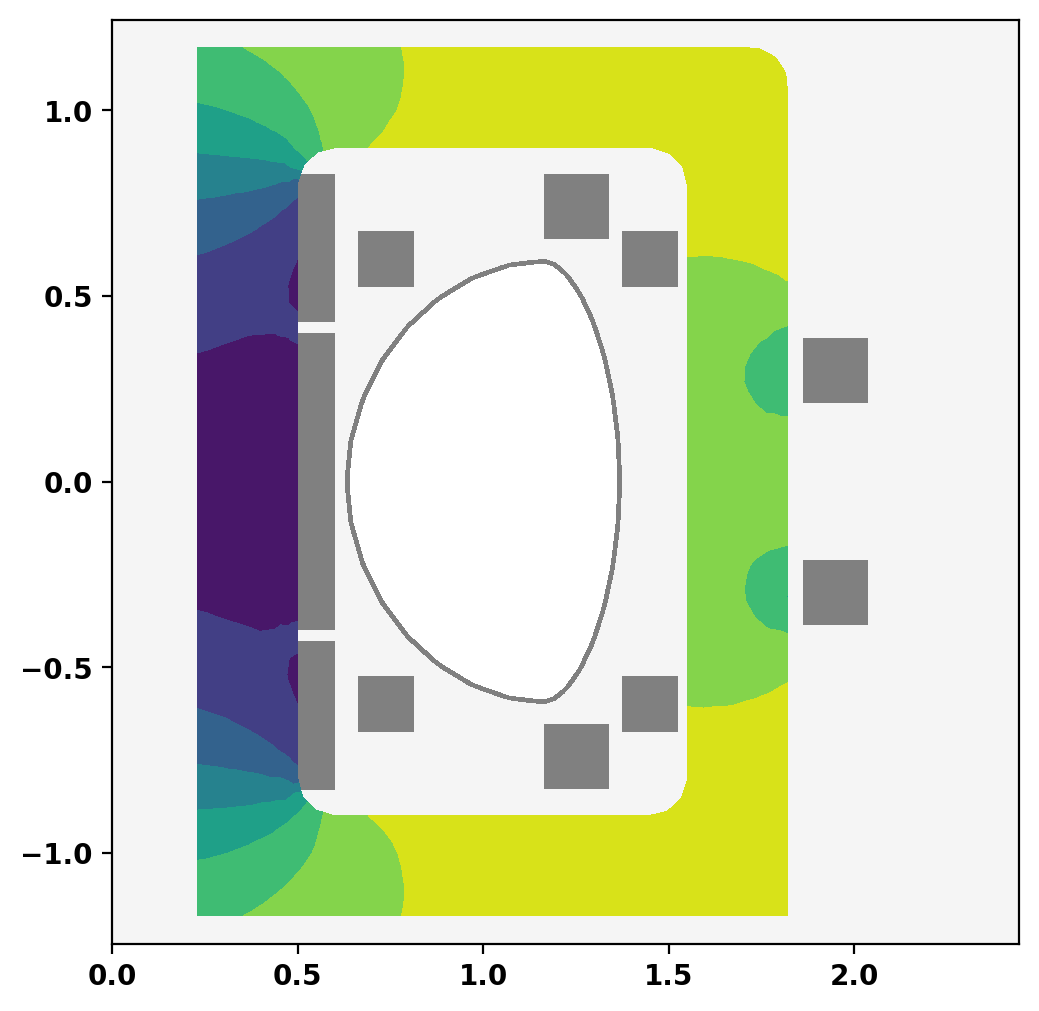

In [12]:
field_eval = mygs.get_field_eval('B')
B_TF = np.zeros((tf_pts.shape[0],3))
for i in range(tf_pts.shape[0]):
    B_TF[i,:] = field_eval.eval(tf_pts[i,:])

# Plot vertical field
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
_ = ax.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,2])

## Setup approximate TF current density on same grid

In [13]:
inner_R0 = 0.230
leg_width = 0.270
bore = 1.050
height = 2.340
inner_radius = 0.100
leg_thickness = 0.190
TF_current = 313.0*3.E3
#
J_TF = np.zeros((tf_pts.shape[0],2))
for i in range(tf_pts.shape[0]):
    if (abs(tf_pts[i,1]) > (height/2.0 - leg_width - inner_radius)) and abs(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0)) > (bore/2.0-inner_radius):
        if tf_pts[i,0] > 1.0:
            R0 = inner_R0+leg_width+bore-inner_radius
        else:
            R0 = inner_R0+leg_width+inner_radius
        Z0 = np.sign(tf_pts[i,1])*(height/2.0-leg_width-inner_radius)
        theta = np.arctan2(tf_pts[i,1]-Z0,tf_pts[i,0]-R0)
        J_TF[i,:] = [-np.sin(theta),np.cos(theta)]
    elif abs(tf_pts[i,1]) >= height/2.0 - leg_width:
        J_TF[i,:] = [-np.sign(tf_pts[i,1]),0.0]
    else:
        J_TF[i,:] = [0.0,np.sign(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0))]
J_TF *= TF_current/leg_width/leg_thickness

## Plot Force inputs

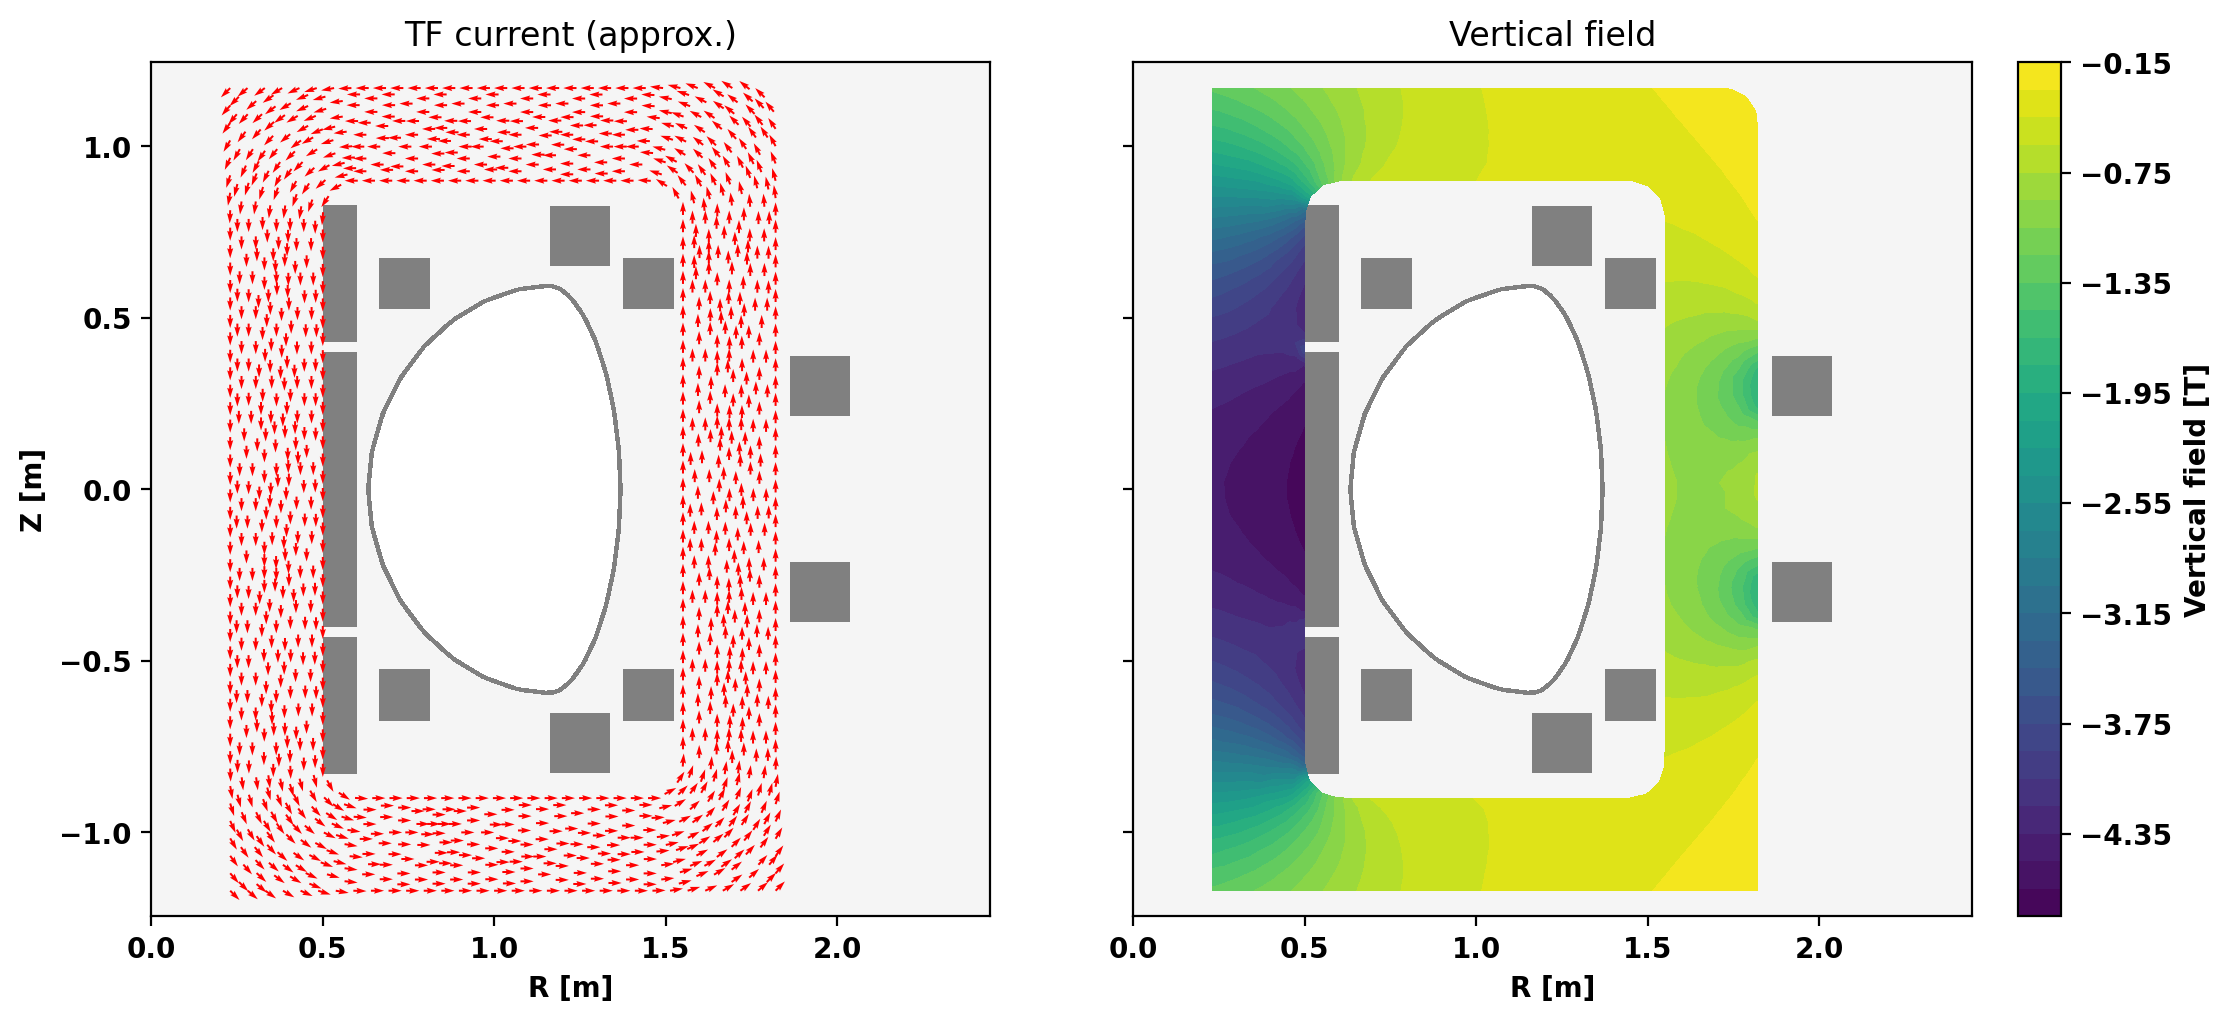

In [14]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(11,5),constrained_layout=True)
mygs.plot_machine(fig,ax[1],limiter_color=None)
clf = ax[1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,2],40)
fig.colorbar(clf,ax=ax[1],label='Vertical field [T]')
ax[1].set_title('Vertical field')
mygs.plot_machine(fig,ax[0],limiter_color=None)
clf = ax[0].quiver(tf_pts[:,0],tf_pts[:,1],J_TF[:,0],J_TF[:,1],color='r')
ax[0].set_title('TF current (approx.)')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[1].set_xlabel('R [m]')
# fig.savefig('NSF-TF_ex.png',dpi=200)

## Plot toroidal pressure (overturning)
Pressure is J_r * B_z * leg_thickness

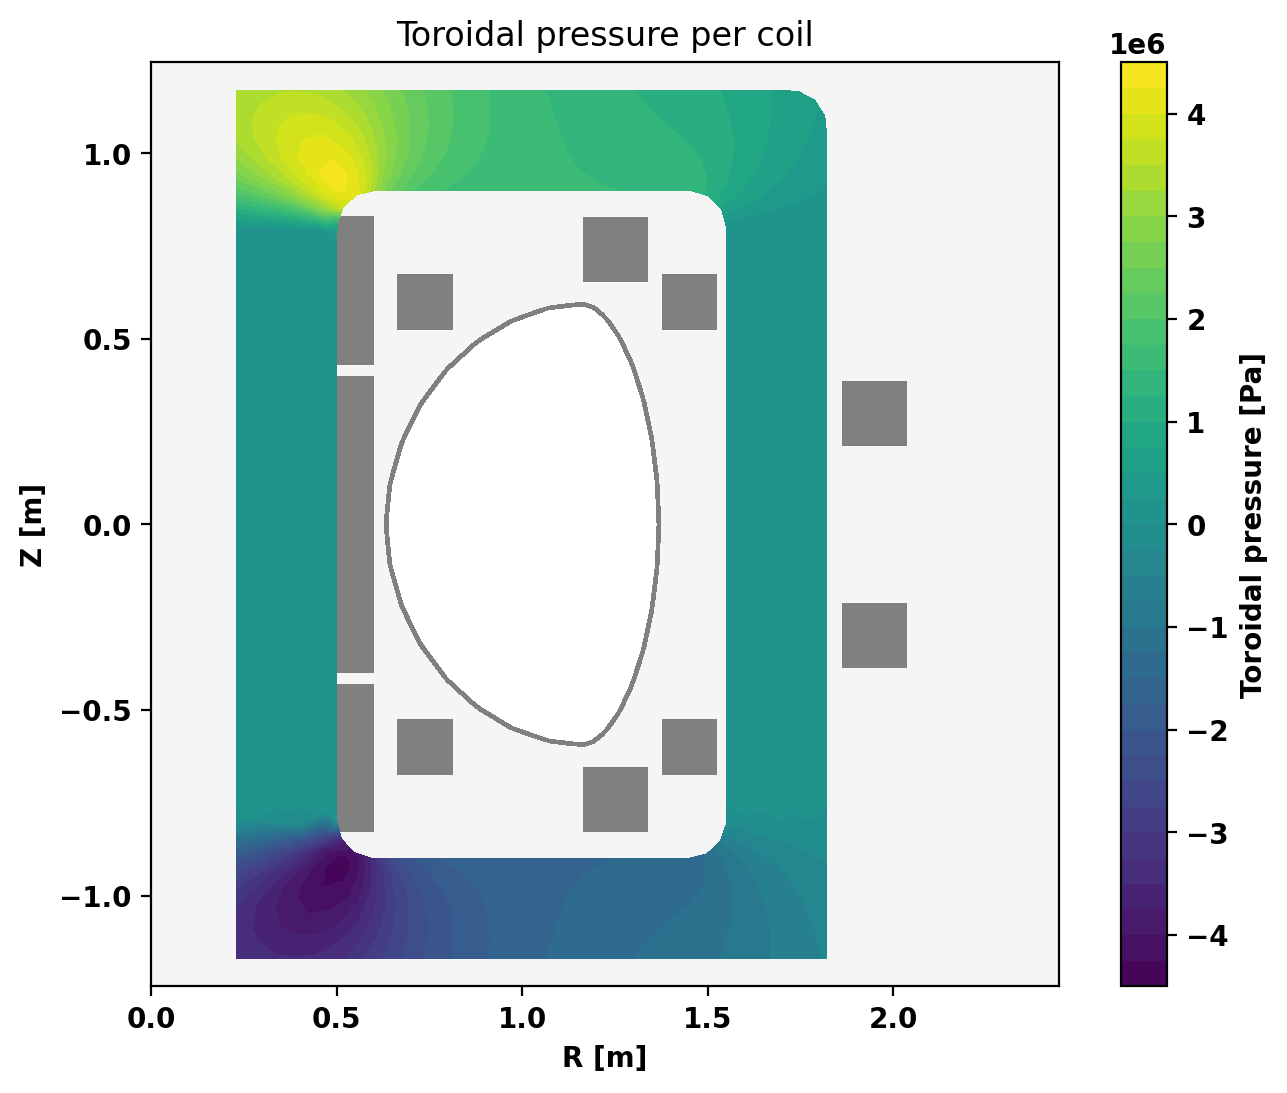

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
mygs.plot_machine(fig,ax,limiter_color=None)
clf = ax.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,J_TF[:,0]*B_TF[:,2]*leg_thickness,40)
fig.colorbar(clf,ax=ax,label='Toroidal pressure [Pa]')
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')
_ = ax.set_title('Toroidal pressure per coil')
# fig.savefig('NSF-TF_forces_ex.png',dpi=200)

## Save raw force information

In [16]:
with open('TF_force.json', 'w+') as fid:
    fid.write(json.dumps({
        "pts": tf_pts.tolist(),
        "lc": tf_lc.tolist(),
        "P_tor": (J_TF[:,0]*B_TF[:,2]*leg_thickness).tolist()
    }))

## Compute total overturning force and moment (per coil)
As the force cancels if intergrated over the whole coil for an up-down symmetric field, the force on one half of the coil is reported.

In [17]:
overturning_force = 0.0
overturning_moment = 0.0
for i in range(tf_lc.shape[0]):
    v1 = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2 = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    Jcc = (J_TF[tf_lc[i,2],0]+J_TF[tf_lc[i,1],0]+J_TF[tf_lc[i,0],0])/3.0
    Bcc = (B_TF[tf_lc[i,2],2]+B_TF[tf_lc[i,1],2]+B_TF[tf_lc[i,0],2])/3.0
    overturning_force += np.sign(rcc[1])*area*Jcc*Bcc*leg_thickness
    overturning_moment += rcc[1]*area*Jcc*Bcc*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN]'.format(overturning_force/2.0/1.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(overturning_moment/1.E3))

Overturning force per half coil =     914.00 [kN]
Overturning moment per coil     =    1865.89 [kN-m]


## Compute force on PF coils

CS0      9.7747E+06     4.6489E+06
CS1      2.3575E+07     1.0716E+03
CS2      9.7722E+06    -4.6498E+06
EF0U     0.0000E+00    -0.0000E+00
EF1U     0.0000E+00    -0.0000E+00
EF2U     0.0000E+00    -0.0000E+00
EF3U     3.3723E+06    -4.0371E+06
EF0L     0.0000E+00    -0.0000E+00
EF1L     0.0000E+00    -0.0000E+00
EF2L     0.0000E+00    -0.0000E+00
EF3L     3.3669E+06     4.0325E+06


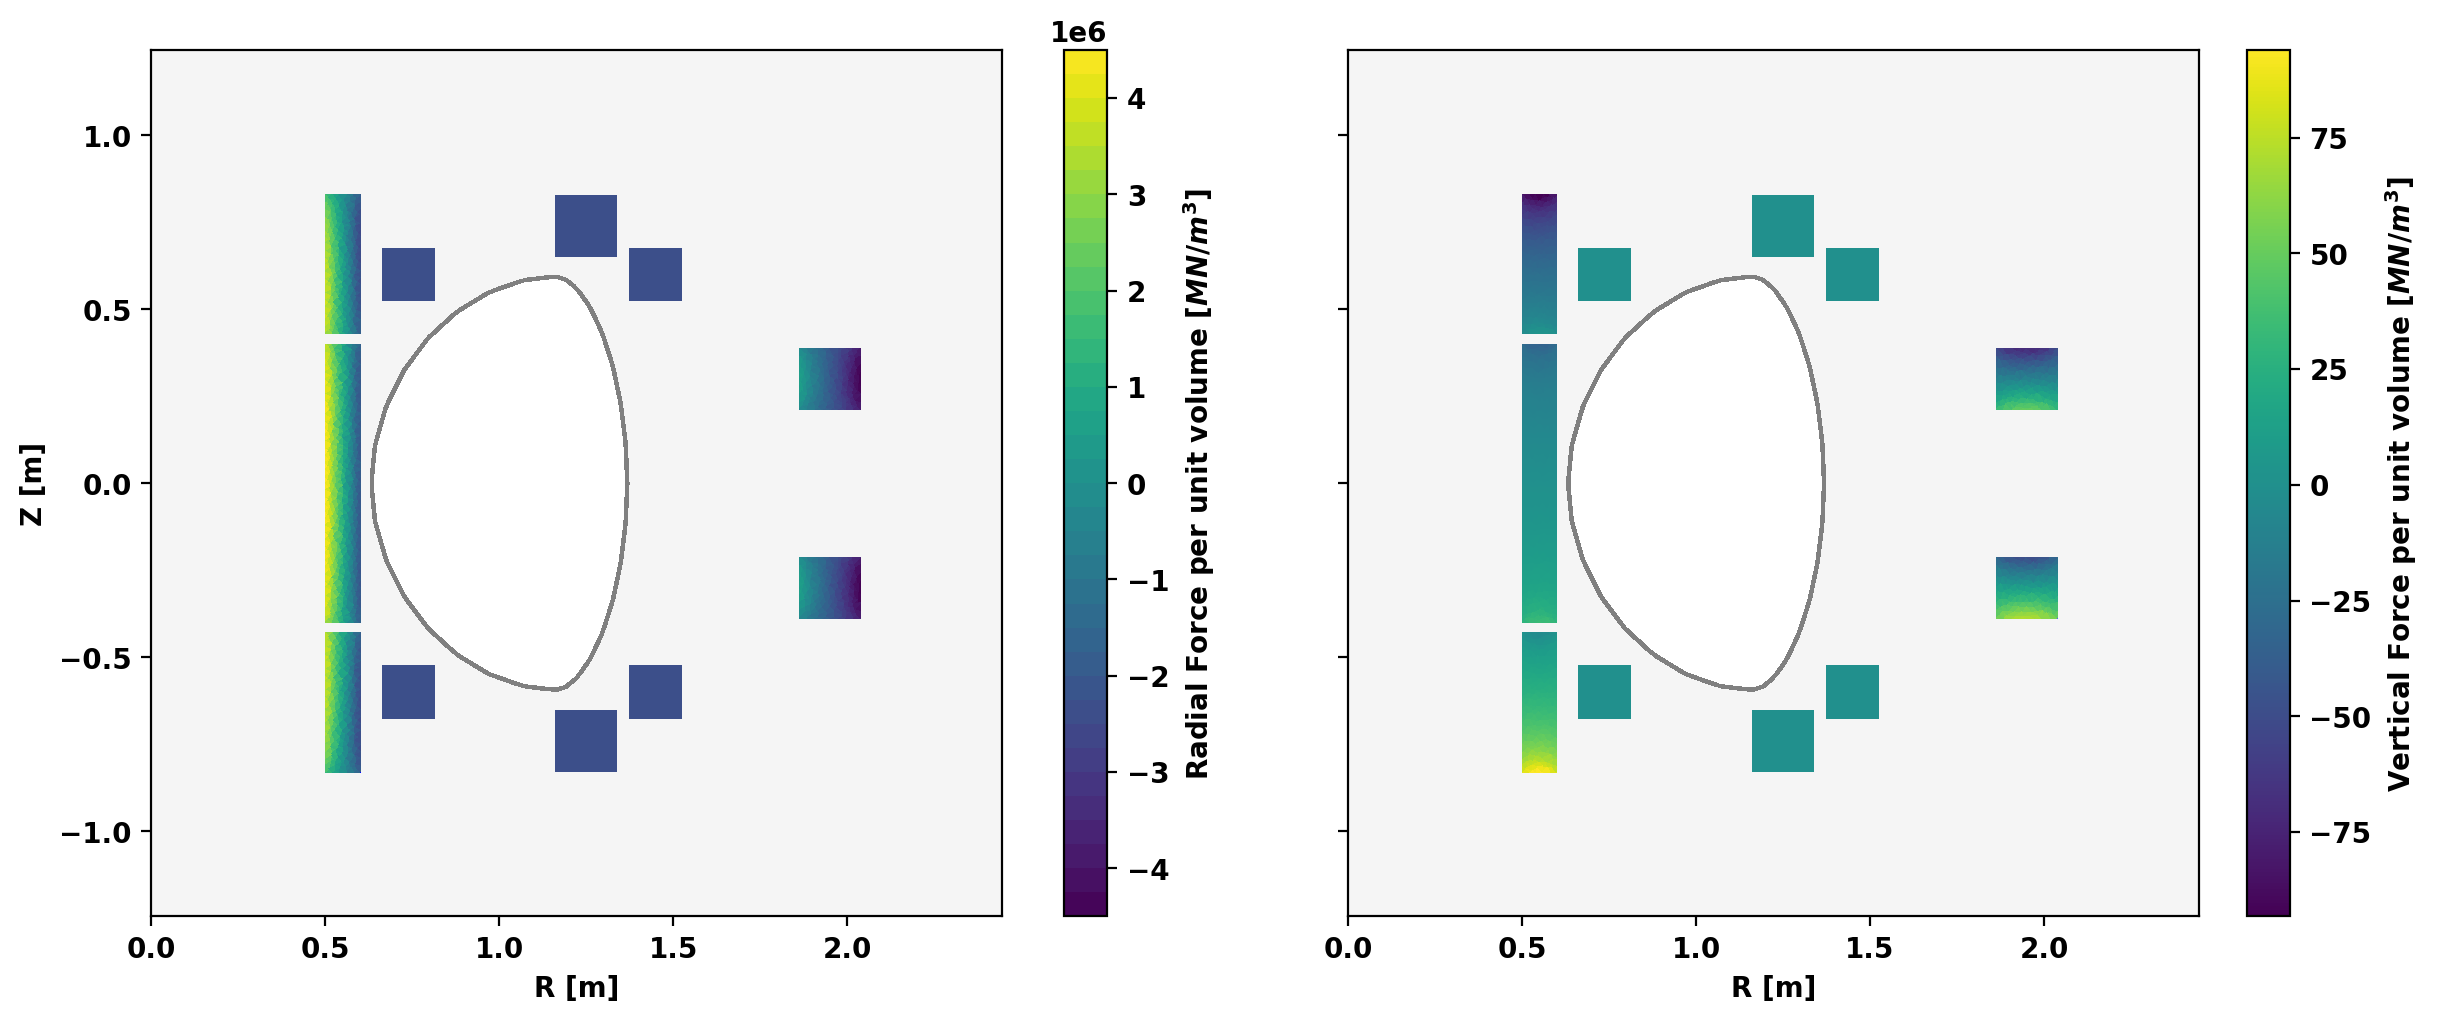

In [18]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.NaN
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1 = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2 = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0],-coil_force[1]))

# Plot results
fig, ax = plt.subplots(1,2,figsize=(12,5),sharey=True,constrained_layout=True)
# Radial force
mygs.plot_machine(fig,ax[0],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6)
fig.colorbar(clf,ax=ax[0],label=r'Radial Force per unit volume [$MN/m^3$]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Vertical force
mygs.plot_machine(fig,ax[1],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
clf = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6)
fig.colorbar(clf,ax=ax[1],label=r'Vertical Force per unit volume [$MN/m^3$]')
_ = ax[1].set_xlabel('R [m]')

# Compute forces on coils for an example equilibrium

## Solve for example NT equilibrium

Starting non-linear GS solver
     1  1.5514E+01  6.8679E+00  1.8474E-02  1.0603E+00  7.3603E-05 -0.0000E+00
     2  1.6211E+01  7.2916E+00  7.3208E-03  1.0585E+00  8.2909E-05 -0.0000E+00
     3  1.6012E+01  7.2756E+00  2.6580E-03  1.0563E+00  8.6838E-05 -0.0000E+00
     4  1.5855E+01  7.2509E+00  1.2697E-03  1.0545E+00  9.3013E-05 -0.0000E+00
     5  1.5753E+01  7.2340E+00  7.4993E-04  1.0531E+00  9.7963E-05 -0.0000E+00
     6  1.5691E+01  7.2236E+00  4.7203E-04  1.0522E+00  1.0184E-04 -0.0000E+00
     7  1.5653E+01  7.2175E+00  2.9846E-04  1.0516E+00  1.0500E-04 -0.0000E+00
     8  1.5630E+01  7.2139E+00  1.8706E-04  1.0513E+00  1.0767E-04 -0.0000E+00
     9  1.5616E+01  7.2118E+00  1.1606E-04  1.0510E+00  1.0998E-04 -0.0000E+00
    10  1.5608E+01  7.2105E+00  7.1371E-05  1.0509E+00  1.1209E-04 -0.0000E+00
    11  1.5603E+01  7.2098E+00  4.3570E-05  1.0508E+00  1.1402E-04 -0.0000E+00
    12  1.5600E+01  7.2093E+00  2.6444E-05  1.0508E+00  1.1580E-04 -0.0000E+00
    13  1.5598E+01  7.

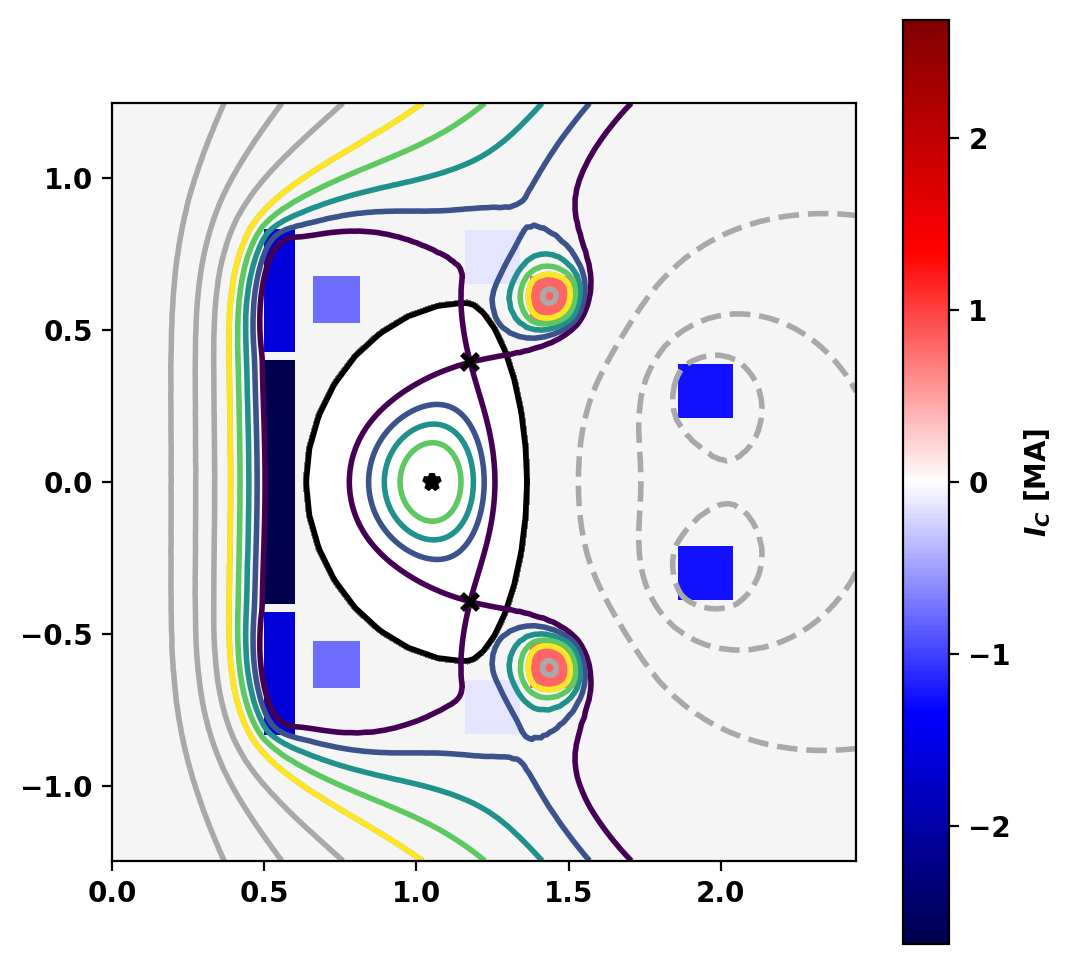

In [19]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
targets[mygs.coil_sets['CS0']['id']] = -1.5E6
targets[mygs.coil_sets['CS1']['id']] = -3.0E6
targets[mygs.coil_sets['CS2']['id']] = -1.5E6

#Enforce up/down symmetry in PF coils using upper coils as the reference
coil_reg_mat[mygs.coil_sets['EF0L']['id'],mygs.coil_sets['EF0U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF0L']['id']] = 1.E1
coil_reg_mat[mygs.coil_sets['EF1L']['id'],mygs.coil_sets['EF1U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF1L']['id']] = 1.E1
coil_reg_mat[mygs.coil_sets['EF2L']['id'],mygs.coil_sets['EF2U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF2L']['id']] = 1.E1
coil_reg_mat[mygs.coil_sets['EF3L']['id'],mygs.coil_sets['EF3U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF3L']['id']] = 1.E1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)

# Define shape of P' and FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

# set boundary/saddle point targets
boundary = create_isoflux(20, 1, 0, 0.2588, 1.5, -0.7)
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)
isoflux_weights = 10*np.ones(len(boundary))

mygs.set_isoflux(boundary, isoflux_weights)

#find equilibrium
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

#plot equilibrium
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,vacuum_nlevels=4,plasma_nlevels=5)

## Compute new forces on TF coils

In [20]:
field_eval = mygs.get_field_eval('B')
B_TF = np.zeros((tf_pts.shape[0],3))
for i in range(tf_pts.shape[0]):
    B_TF[i,:] = field_eval.eval(tf_pts[i,:])
#
inner_R0 = 0.230
leg_width = 0.270
bore = 1.050
height = 2.340
inner_radius = 0.100
leg_thickness = 0.190
TF_current = 313.0*3.E3
#
J_TF = np.zeros((tf_pts.shape[0],2))
for i in range(tf_pts.shape[0]):
    if (abs(tf_pts[i,1]) > (height/2.0 - leg_width - inner_radius)) and abs(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0)) > (bore/2.0-inner_radius):
        if tf_pts[i,0] > 1.0:
            R0 = inner_R0+leg_width+bore-inner_radius
        else:
            R0 = inner_R0+leg_width+inner_radius
        Z0 = np.sign(tf_pts[i,1])*(height/2.0-leg_width-inner_radius)
        theta = np.arctan2(tf_pts[i,1]-Z0,tf_pts[i,0]-R0)
        J_TF[i,:] = [-np.sin(theta),np.cos(theta)]
    elif abs(tf_pts[i,1]) >= height/2.0 - leg_width:
        J_TF[i,:] = [-np.sign(tf_pts[i,1]),0.0]
    else:
        J_TF[i,:] = [0.0,np.sign(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0))]
J_TF *= TF_current/leg_width/leg_thickness

In [21]:
overturning_force = 0.0
overturning_moment = 0.0
for i in range(tf_lc.shape[0]):
    v1 = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2 = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    Jcc = (J_TF[tf_lc[i,2],0]+J_TF[tf_lc[i,1],0]+J_TF[tf_lc[i,0],0])/3.0
    Bcc = (B_TF[tf_lc[i,2],2]+B_TF[tf_lc[i,1],2]+B_TF[tf_lc[i,0],2])/3.0
    overturning_force += np.sign(rcc[1])*area*Jcc*Bcc*leg_thickness
    overturning_moment += rcc[1]*area*Jcc*Bcc*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN]'.format(overturning_force/2.0/1.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(overturning_moment/1.E3))

Overturning force per half coil =     710.10 [kN]
Overturning moment per coil     =    1444.50 [kN-m]


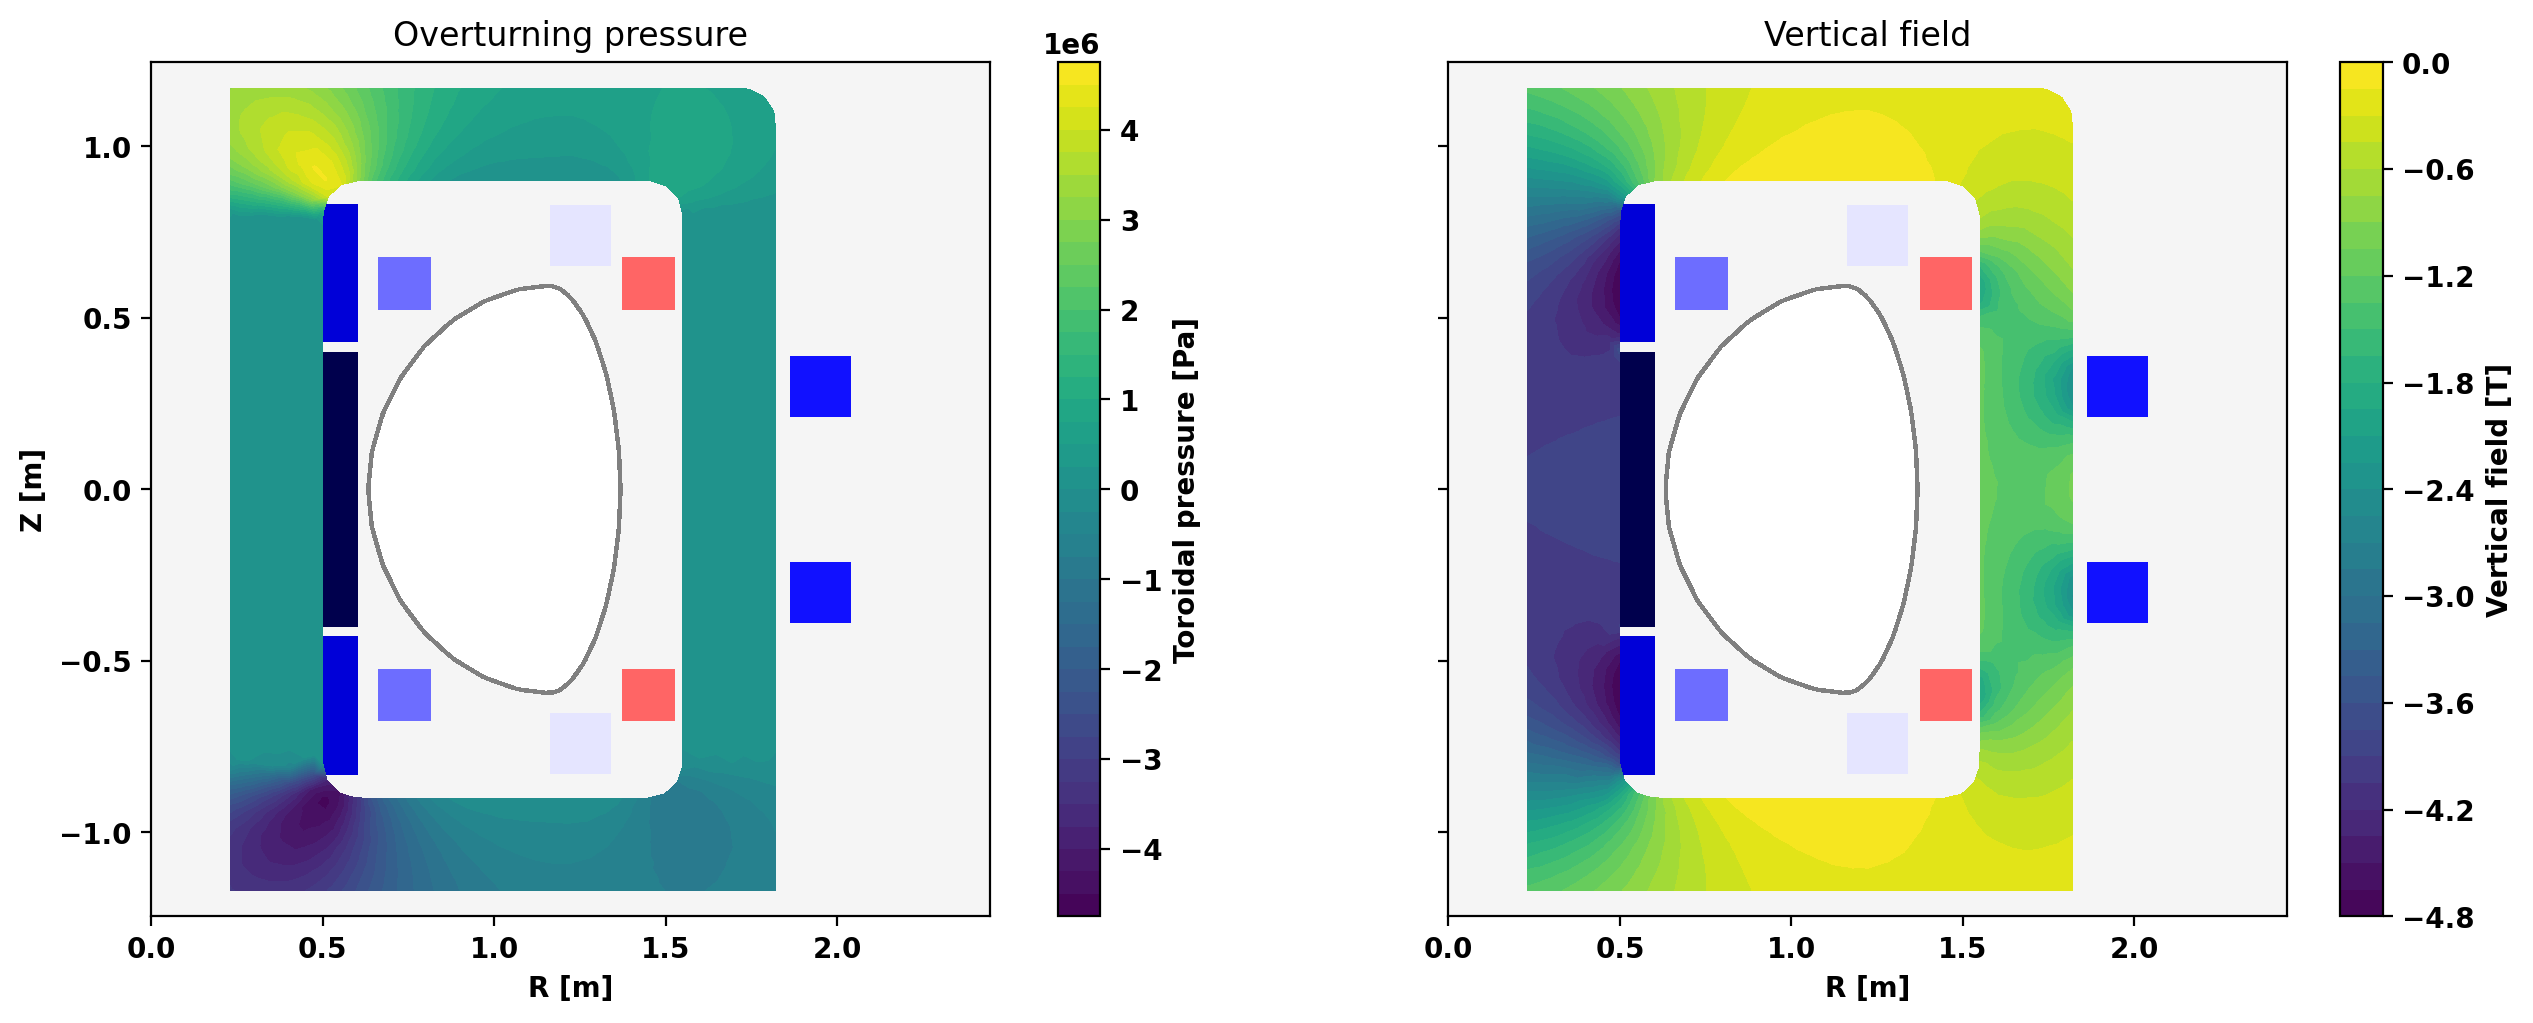

In [22]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(13,5),constrained_layout=True)
mygs.plot_machine(fig,ax[1],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
clf = ax[1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,2],40)
fig.colorbar(clf,ax=ax[1],label='Vertical field [T]')
_ = ax[1].set_title('Vertical field')

mygs.plot_machine(fig,ax[0],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
clf = ax[0].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,J_TF[:,0]*B_TF[:,2]*leg_thickness,40)
fig.colorbar(clf,ax=ax[0],label='Toroidal pressure [Pa]')
_ = ax[0].set_title('Overturning pressure')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[1].set_xlabel('R [m]')

## Compute new forces on PF coils

CS0      2.0412E+06     6.5742E+05
CS1      2.5546E+06     5.8866E+02
CS2      2.0429E+06    -6.5833E+05
EF0U    -6.2264E+04    -1.8027E+05
EF1U    -5.5280E+04     1.4154E+04
EF2U    -4.2795E+05     3.0168E+05
EF3U     1.1797E+06    -9.5071E+05
EF0L    -6.1394E+04     1.8052E+05
EF1L    -5.5445E+04    -1.4262E+04
EF2L    -4.2811E+05    -3.0458E+05
EF3L     1.1804E+06     9.5012E+05


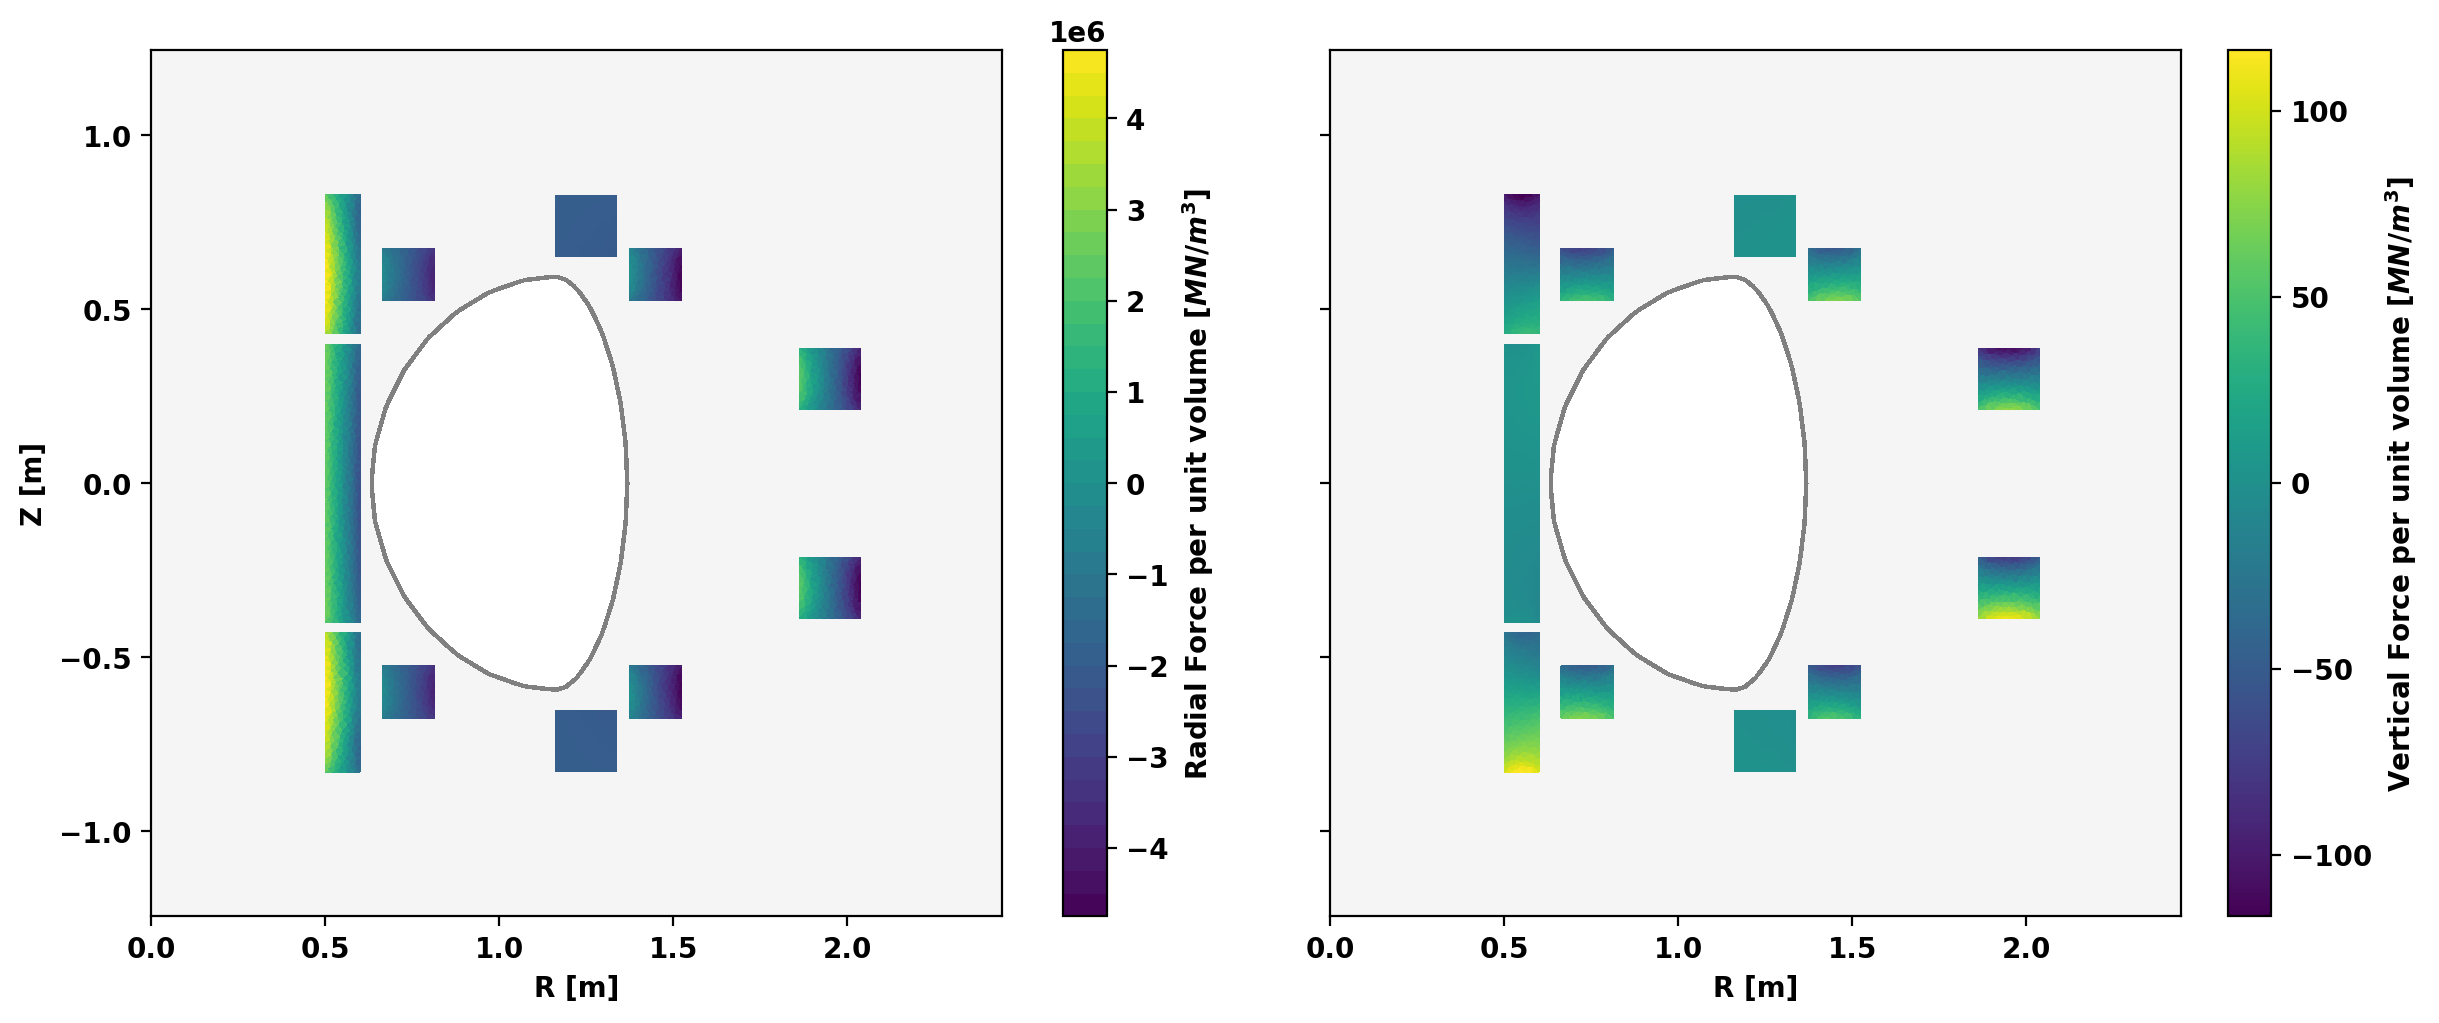

In [23]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.NaN
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1 = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2 = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0]/(2.0*np.pi),-coil_force[1]/(2.0*np.pi)))

# Plot results
fig, ax = plt.subplots(1,2,figsize=(12,5),sharey=True,constrained_layout=True)
# Radial force
mygs.plot_machine(fig,ax[0],limiter_color=None)
ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6)
fig.colorbar(clf,ax=ax[0],label=r'Radial Force per unit volume [$MN/m^3$]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Vertical force
mygs.plot_machine(fig,ax[1],limiter_color=None)
clf = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6)
fig.colorbar(clf,ax=ax[1],label=r'Vertical Force per unit volume [$MN/m^3$]')
_ = ax[1].set_xlabel('R [m]')